In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [2]:
def create_fast(X):
    """Create bigger matrix filled with x - y pairs."""
    n, d = X.shape
    pairs = np.kron(np.ones((n, 1)), X) - np.kron(X, np.ones((n, 1)))
    rk1_matrices = np.kron(np.ones((1, d)), pairs) * np.kron(pairs, np.ones((1, d)))
    return rk1_matrices

In [3]:
def hinge(u, y, b):
    """Hinge loss."""
    return np.maximum(0, 1 - y * (b - u))

In [4]:
def create_mahalanobis(M):
    """Squared Mahalanobis distance."""
    return lambda x, y: (x - y) @ M @ (x - y)

In [5]:
def create_fast_mahalanobis(flat_M):
    """Fast version of Mahalanobis (memory-expensive)."""
    return lambda big_x: flat_M @ big_x

In [6]:
def loss(M, X, y, b=2, fast_X=None):
    """Hinge loss for metric learning."""
    if fast_X is None:
        fast_X = create_fast(X)
    # fast_dist = create_fast_mahalanobis(M.ravel())
    all_dists = fast_X @ M.ravel()
    pair_y = np.kron(y, y)
    return np.average(hinge(all_dists, pair_y, b))

In [7]:
def grad_dist(M, X, y, b=2, fast_X=None):
    """Gradient of the hinge loss."""
    if fast_X is None:
        fast_X = create_fast(X)
    pair_y = np.kron(y, y)
    all_dists = fast_X @ M.ravel()
    return np.sum(
        np.outer(pair_y * (hinge(all_dists, pair_y, b) > 0), np.ones(fast_X.shape[1]))
        * fast_X,
        axis=0,
    ).reshape(M.shape)

In [8]:
def positive_cone(M):
    """Project on the semi-definite positive cone."""
    eigval, eigvec = np.linalg.eigh(M)
    projected_eigval = (eigval > 0) * eigval
    return (projected_eigval * eigvec.T) @ eigvec

In [9]:
def create_mini_batch(X, y, batch_size):
    """Randomly select a mini-batch from the data."""
    indices = np.random.choice(X.shape[0], batch_size, replace=False)
    return X[indices], y[indices]

In [10]:
# n = 400
# d = 15
# mu_0 = np.zeros(d)
# mu_0[0] = 1.0
# mu_1 = np.zeros(d)
# mu_1[0] = -1.0
# cov = 0.01 * np.eye(d)
# X = np.zeros((2 * n, d))
# y = np.zeros(2 * n, dtype=int)
# X[:n] = np.random.multivariate_normal(mu_0, cov, n)
# y[:n] = 1
# X[n:] = np.random.multivariate_normal(mu_1, cov, n)
# y[n:] = -1

In [11]:
X = np.load("mnist_train.npy")
y = np.load("mnist_train_labels.npy")
X_test = np.load("mnist_test.npy")
y_test = np.load("mnist_test_labels.npy")

In [12]:
pca = PCA(n_components=164, svd_solver="full")
X = pca.fit_transform(X)
X_test = pca.transform(X_test)

In [13]:
X = normalize(X, norm="l2", axis=1)
X_test = normalize(X_test, norm="l2", axis=1)

In [22]:
shuffled_indices = np.random.permutation(X.shape[0])
X, y = X[shuffled_indices], y[shuffled_indices]

n_train = len(X) - 40

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:], y[n_train:]

print(
    f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}"
)

X_train: (59960, 164), y_train: (59960,), X_val: (40, 164), y_val: (40,)


In [23]:
step = 5e-4
n_iter = 5000
b = 2
batch_size = 8
score = np.zeros(n_iter + 1)

In [24]:
fast_X_val = create_fast(X_val)

In [25]:
d = X.shape[1]
print(d)

164


# Case with M initiliased randomly

In [26]:
M = np.random.randn(d, d)
score = np.zeros(n_iter + 1)
score[0] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)
for i in range(n_iter):
    X_batch, y_batch = create_mini_batch(X, y, batch_size)
    fast_X_batch = create_fast(X_batch)
    M = positive_cone(
        M - step * grad_dist(M, X_batch, y_batch, b=b, fast_X=fast_X_batch)
    )

    # score on val
    score[i + 1] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)

    if i % 500 == 0:
        print(f"iter {i+1}, score {score[i+1]}")

        if score[i + 1] > score[i - 499] and i > 0:
            break

iter 1, score 194.3223384020549
iter 501, score 54.79932635256105
iter 1001, score 19.03116403744816
iter 1501, score 4.9871708545472915
iter 2001, score 1.6377963345414823
iter 2501, score 2.098559440357337


In [30]:
# generate 10 c

(40,)

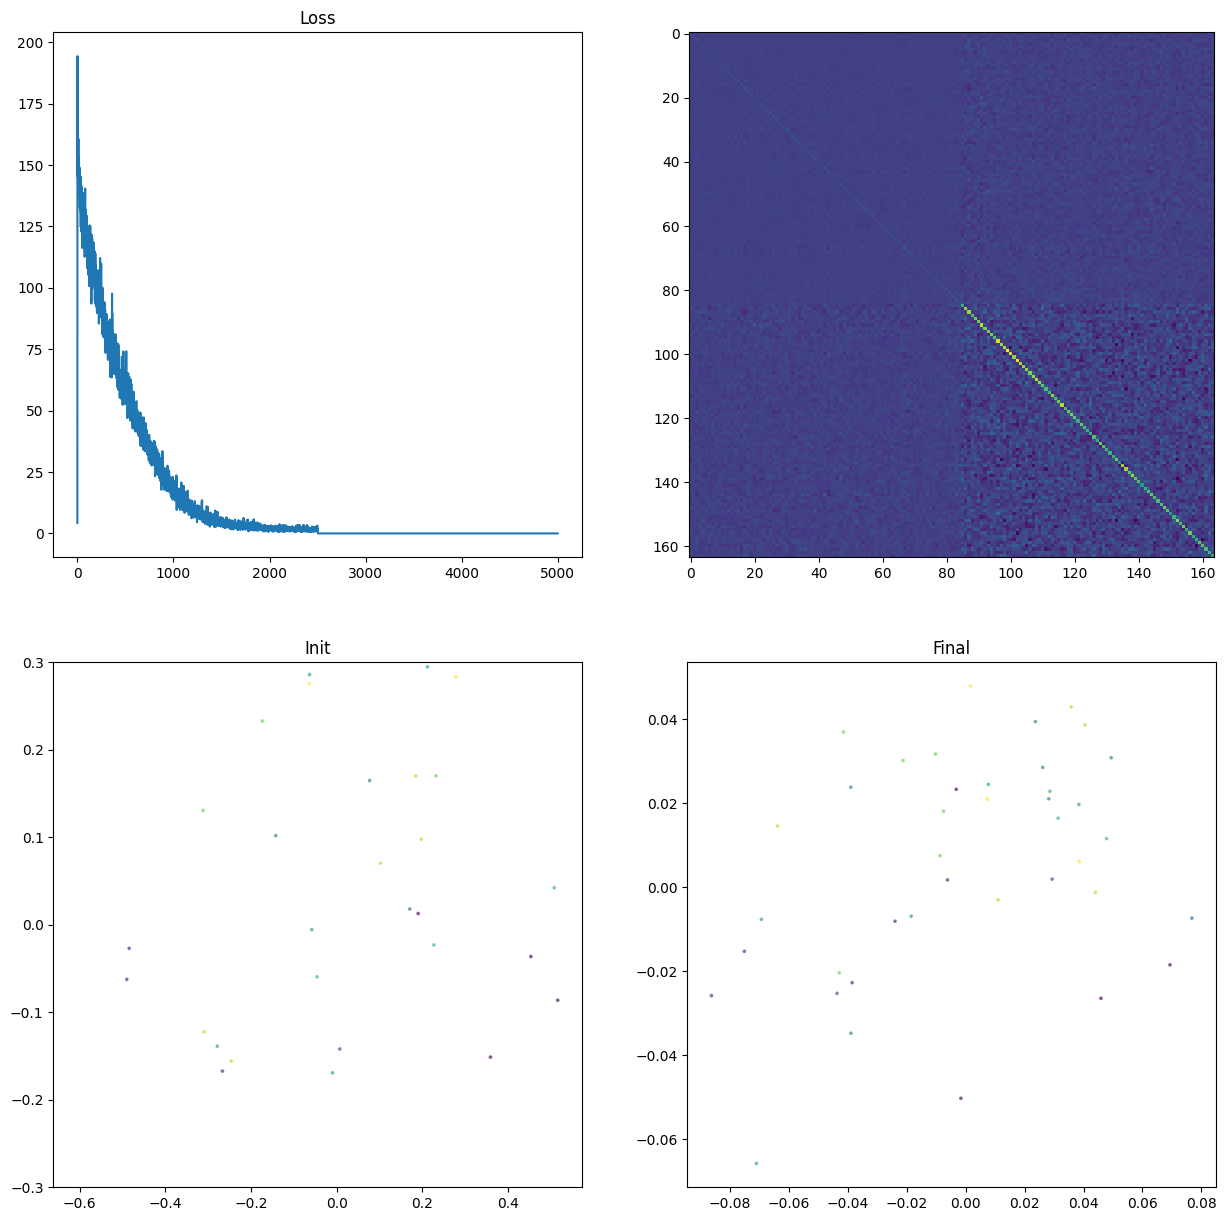

In [33]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(score)
plt.title("Loss")

plt.subplot(2, 2, 3)
colors = np.array(["b", "r"])
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=3, alpha=0.5)
plt.ylim([-0.3, 0.3])
plt.title("Init")

plt.subplot(2, 2, 4)
sqrt_M = scipy.linalg.sqrtm(M)
transf_X = X_val @ sqrt_M
plt.scatter(transf_X[:, 0], transf_X[:, 1], c=y_val, s=3, alpha=0.5)
# plt.ylim([-0.3, 0.3])
plt.title("Final")

plt.subplot(2, 2, 2)
plt.imshow(M)
# for (j, i), label in np.ndenumerate(M):
#     plt.text(i, j, np.round(label, 3), ha="center", va="center")
plt.show()

# Case with M initiliased as identity matrix

In [34]:
M = np.eye(d)
score = np.zeros(n_iter + 1)
score[0] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)
for i in range(n_iter):
    X_batch, y_batch = create_mini_batch(X, y, batch_size)
    fast_X_batch = create_fast(X_batch)
    M = positive_cone(
        M - step * grad_dist(M, X_batch, y_batch, b=b, fast_X=fast_X_batch)
    )

    # score on val
    score[i + 1] = loss(M, X_val, y_val, b=b, fast_X=fast_X_val)

    if i % 500 == 0:
        print(f"iter {i+1}, score {score[i+1]}")

        if score[i + 1] > score[i - 499] and i > 0:
            break

iter 1, score 2.796196431465124
iter 501, score 0.19279649705117266
iter 1001, score 0.19189842006603974
iter 1501, score 0.1912761366632215
iter 2001, score 0.1910709434776517
iter 2501, score 0.19108121442969242


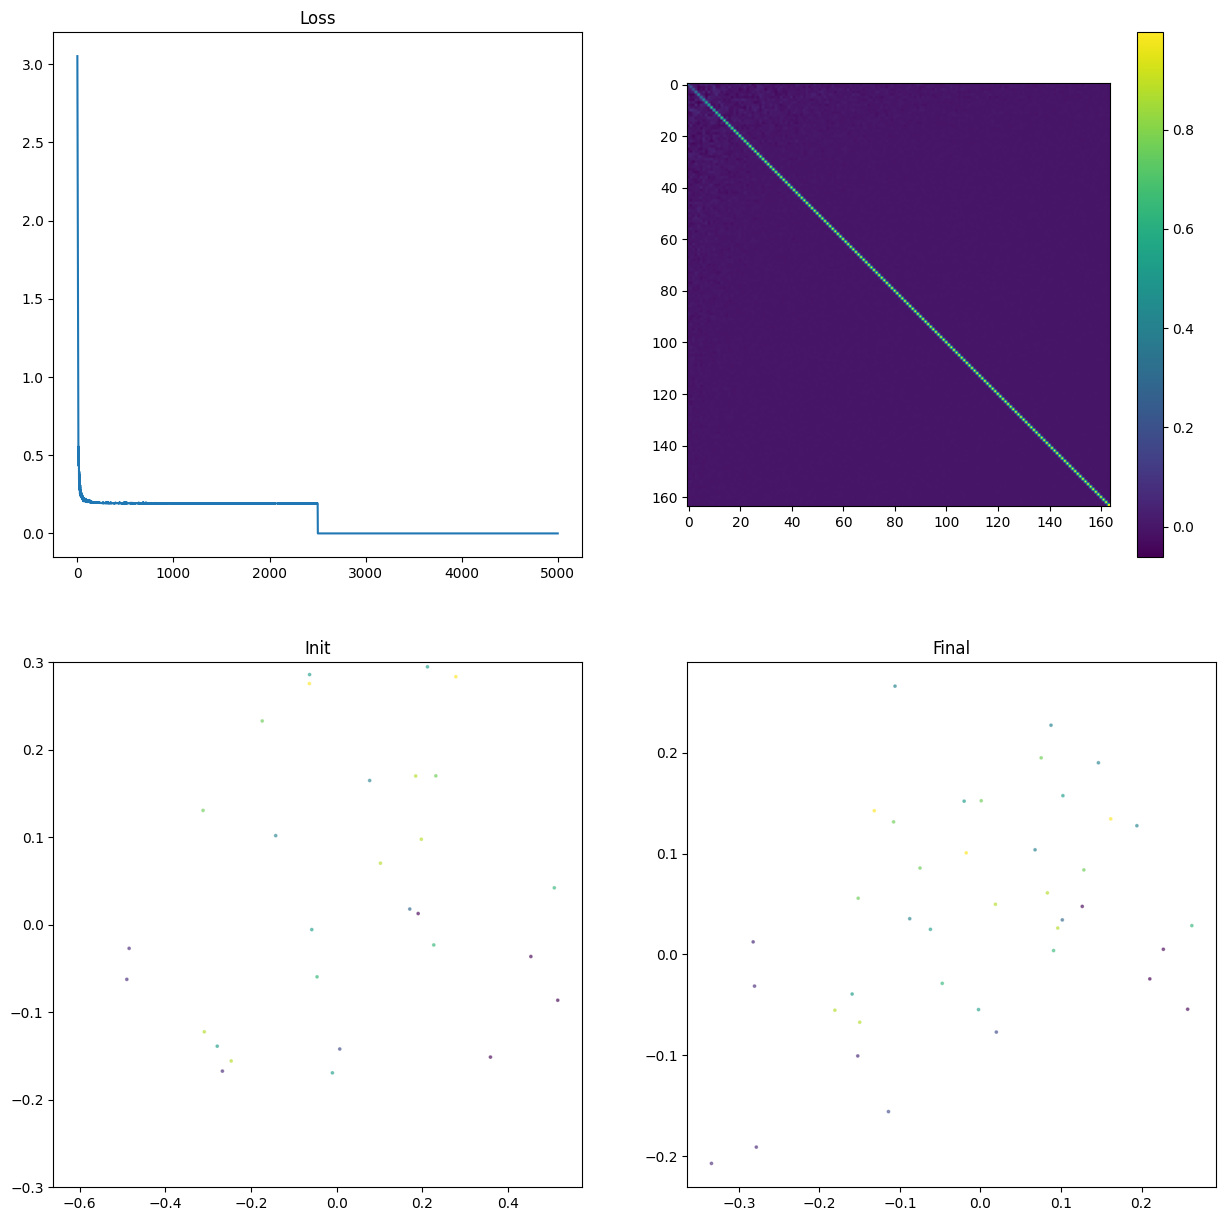

In [39]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(score)
plt.title("Loss")

plt.subplot(2, 2, 3)
colors = np.array(["b", "r"])
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=3, alpha=0.5)
plt.ylim([-0.3, 0.3])
plt.title("Init")

plt.subplot(2, 2, 4)
sqrt_M = scipy.linalg.sqrtm(M)
transf_X = X_val @ sqrt_M
plt.scatter(transf_X[:, 0], transf_X[:, 1], c=y_val, s=3, alpha=0.5)
# plt.ylim([-0.3, 0.3])
plt.title("Final")

plt.subplot(2, 2, 2)
plt.imshow(M)
plt.colorbar()
plt.show()